In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import *
from keras.layers import Embedding,Bidirectional
from keras.layers import Input, Dense
from keras.layers import Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D
from keras.layers import SpatialDropout1D,LSTM,BatchNormalization,Dropout
from keras.layers import merge,concatenate
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam,SGD
from keras.initializers import Constant
import keras.backend as K


In [2]:
from keras.engine.topology import Layer

In [3]:
from keras.callbacks import EarlyStopping

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

In [7]:
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string

In [8]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
doc = nlp("This is a sentence.")

/home/corrine1106/.conda/envs/py3.7/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [9]:
#for plural nuons
import inflect

### import data

In [10]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

## EDA

### Common stopwords

In [623]:
new_stop = stop-set(['what',
 'when',
 'where',
 'which',
 'while',
 'whom',
 'over'])

# Data Cleaning

In [289]:
train_index = len(train)

In [1117]:
df = pd.concat([train,test])
df = df.reset_index(drop=True)

In [1118]:
df.Headline[0]

"Golden, gaudy and glorious: Dubai has the world's tallest building and biggest airport... is it about to overtake London as the most visited city?"

In [1119]:
sport = ['sport', 'football',  'golf', 'rugbyunion', 'boxing', 'tennis','othersports']
non_sport = ['travel', 'health', 'femail', 'gardening', 'sciencetech',
       'news', 'food',  'travelnews', 'cricket', 
       'books', 'home', 'concussion','beauty', 'formulaone', 'racing', 'living',
       'middleeast', 'us']

In [1120]:
df_sport = pd.DataFrame([])
for i in sport:
    df_sport = df_sport.append(df[df['Category'] == i])


In [1121]:
df_non_sport = pd.DataFrame([])
for i in non_sport:
    df_non_sport = df_non_sport.append(df[df['Category'] == i])


### clean puctuation

In [1122]:
df_non_sport['Headline']=df_non_sport['Headline'].apply(lambda x : x.replace("'s",' '))
df_non_sport['Headline']=df_non_sport['Headline'].apply(lambda x : x.replace("s'",' '))
df_sport['Headline']=df_sport['Headline'].apply(lambda x : x.replace("'s",' '))
df_sport['Headline']=df_sport['Headline'].apply(lambda x : x.replace("s'",' '))

In [1123]:
df_sport.head()

,ID,Headline,Category,Label
4,5,Luis Suarez bite has ensured his legacy as a ...,sport,4.000000
59,60,"Premier League top 10 debuts: Diego Costa, Ces...",sport,3.000000
219,220,Yoann Huget warned by The European Professiona...,sport,2.000000
314,315,Dani Alves reaches 300 appearances for Barcelo...,sport,2.000000
338,339,Andre-Pierre Gignac transfer from Toulouse to...,sport,2.333333


In [1124]:
punctuation = '"#$%&\'()*+,./:;<=>@[\\]^_`{|}~!?'

In [1125]:
def remove_punct(text):
    table=str.maketrans('','',punctuation)
    return text.translate(table)

In [1126]:
example="Sorry, i spent it on myself! Harvey Nichol's hilarious Christmas advert sees people treating themselves instead of others"
print(remove_punct(example))

Sorry i spent it on myself Harvey Nichols hilarious Christmas advert sees people treating themselves instead of others


### football club

In [1127]:
football_club_list = ['Alavés','Athletic Bilbao','Atlético Madrid','Barcelona'
                      ,'Cádiz','Celta Vigo','Eibar','Elche','Getafe','Granada'
                     ,'Huesca','Levante','Osasuna','Real Betis','Real Madrid','Real Sociedad','Sevilla'
                     ,'Valencia','Valladolid','Villarreal']

In [1128]:
def football_club(title):
    word_list = title.split(' ')
    for word in word_list:
        if word in football_club_list:
            title = title.replace(word,'football club')
    return title

In [1129]:
df_sport['Headline']=df_sport['Headline'].apply(lambda x : football_club(x))

In [1130]:
footballer_list = ['Paul Pogba','Dejan Lovren']

In [1131]:
def footballer(title):
    word_list = title.split(' ')
    for word in word_list:
        if word in footballer_list:
            title = title.replace(word,'footballer')
    return title

In [1132]:
df_sport['Headline']=df_sport['Headline'].apply(lambda x : footballer(x))

In [1133]:
re.findall(r"£ \d*\,?\d+\.?\d*",df.Headline[1])

['£ 180', '£ 5']

In [1134]:
def replace_money(title):
    money_list = re.findall(r"£ \d*\,?\d+\.?\d*",title)
    if not money_list:
        return title
    else:
        for money in money_list:
            title = title.replace(money, 'money')
        return title

In [1135]:
def remove_name(title):
    doc = nlp(title)
    if not doc.ents :
        return title
    else:
        for X in doc.ents:
            if X.label_=='PERSON':
                title = title.replace(X.text, ' ')
                
    return title
            
def remove_date(title):
    doc = nlp(title)
    if not doc.ents :
        return title
    else:
        for X in doc.ents:
            if X.label_=='DATE':
                title = title.replace(X.text, ' ')
                
    return title

In [1136]:
def replace_name(title):
    doc = nlp(title)
    if not doc.ents :
        return title
    else:
        for X in doc.ents:
            if X.label_=='PERSON':
                print(title)
                title = title.replace(X.text, 'athlete')
        return title

In [1137]:
df_sport['Headline']=df_sport['Headline'].apply(lambda x : remove_name(x))

In [1138]:
df = df_sport.append(df_non_sport)

In [1140]:
df['Headline']=df['Headline'].apply(lambda x : remove_date(x))

In [1141]:
df['Headline']=df['Headline'].apply(lambda x : replace_money(x))

In [1142]:
df['Headline']=df['Headline'].apply(lambda x : remove_punct(x))

In [1143]:
df.Headline[0]

'Golden gaudy and glorious Dubai has the world  tallest building and biggest airport is it about to overtake London as the most visited city'

In [1144]:
other_stop = set(["would",'could','new','hi','say','world','reveal','money','first','one','reveals','says','over'])

In [1145]:
df['text']=df['Headline'].apply(lambda x : remove_punct(x))
df['tokenized'] = df['Headline'].apply(word_tokenize)



df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

df['no_stopwords'] = df['lower'].apply(lambda x: [word for word in x if word not in new_stop]) #if word not in new_stop
df['no_stopwords'] = df['no_stopwords'].apply(lambda x: [word for word in x if word not in other_stop])
df['no_stopwords'] = [' '.join(map(str, l)) for l in df['no_stopwords']]

In [1146]:
df['no_stopwords'] = df['no_stopwords'].apply(lambda x: x.replace("polouse", 'scenery'))

In [1147]:
df_label_list = []
for label in df.Label.unique():
    if np.isnan(label) == False:
        df_label_list.append(df[df['Label'] == label])
label_top = defaultdict(list)
for df_label in df_label_list:
    corpus = create_corpus(df_label,'no_stopwords')
    dic=defaultdict(int)
    for word in corpus:
        dic[word]+=1
        
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    label_top[df_label.Label.unique()[0]] = top

In [1148]:
df = df.sort_index()

In [1149]:
corpus = create_corpus(df,'Headline')
dic=defaultdict(int)
for word in corpus:
    dic[word]+=1

<AxesSubplot:>

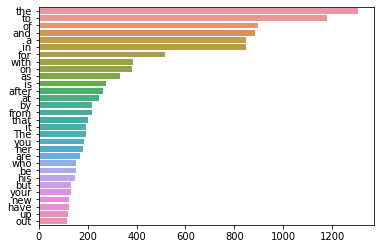

In [1150]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:30]:
    x.append(word)
    y.append(count)
sns.barplot(x=y,y=x)

In [1151]:
most

[('the', 1304),
 ('to', 1179),
 ('of', 897),
 ('and', 885),
 ('a', 847),
 ('in', 846),
 ('for', 517),
 ('with', 384),
 ('on', 382),
 ('as', 331),
 ('is', 277),
 ('after', 263),
 ('at', 246),
 ('by', 219),
 ('from', 218),
 ('that', 200),
 ('it', 195),
 ('The', 192),
 ('you', 185),
 ('her', 182),
 ('are', 169),
 ('who', 154),
 ('be', 152),
 ('his', 149),
 ('but', 134),
 ('your', 133),
 ('new', 123),
 ('have', 122),
 ('up', 118),
 ('out', 117),
 ('could', 104),
 ('money', 103),
 ('he', 101),
 ('can', 100),
 ('she', 100),
 ('world', 96),
 ('was', 95),
 ('first', 91),
 ('will', 88),
 ('their', 88),
 ('has', 87),
 ('they', 85),
 ('an', 84),
 ('reveals', 80),
 ('one', 80),
 ('more', 79),
 ('how', 79),
 ('just', 74),
 ('says', 73),
 ('most', 69),
 ('over', 69),
 ('its', 69),
 ('not', 68),
 ('A', 68),
 ('than', 67),
 ('into', 64),
 ('or', 63),
 ('all', 62),
 ('get', 56),
 ('off', 56),
 ('Is', 55),
 ('being', 55),
 ('people', 54),
 ('best', 54),
 ('i', 53),
 ('life', 53),
 ('time', 53),
 ('back'

In [1152]:
labels = train.Label.values.reshape(-1,1)

### Tokenizer

In [1153]:
len(train_reduce)

1975

In [1154]:
train_index = len(train)

In [1155]:
MAX_NB_WORDS = 9000
MAX_SEQUENCE_LENGTH = 30

#texts = train.Headline.append(test.Headline).reindex()
texts = df.no_stopwords

VALIDATION_SPLIT = 0.1

tokenizer = Tokenizer() #num_words=MAX_NB_WORDS
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



Found 9505 unique tokens.


In [1156]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set

test_data = data[train_index:]
data = data[:train_index]

Shape of data tensor: (2267, 30)
Shape of label tensor: (2040, 1)


In [1157]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


In [1158]:
category_dict = defaultdict(int)
for number,item in enumerate(df.Category.unique()):
    category_dict[item] = number

In [1159]:
df['Category_number'] = df['Category'].apply(lambda x : category_dict[x])

In [1160]:
x_train_category = df.Category_number[indices][:-nb_validation_samples]
x_val_category = df.Category_number[indices][-nb_validation_samples:]
x_test_category = df.Category_number[train_index:]

In [1161]:
x_train_category

756     5
1109    6
121     5
1293    7
278     8
       ..
584     2
630     7
1696    2
1444    6
401     8
Name: Category_number, Length: 1836, dtype: int64

In [1162]:
depth = 25
x_train_category = tf.one_hot(x_train_category, depth=depth)
x_val_category = tf.one_hot(x_val_category, depth=depth)
x_test_category = tf.one_hot(x_test_category, depth=depth)

In [1163]:
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [1164]:
y_val

<tf.Tensor: shape=(204, 1), dtype=float32, numpy=
array([[3.3333333],
       [3.3333333],
       [2.       ],
       [3.6666667],
       [4.       ],
       [4.       ],
       [2.6666667],
       [3.3333333],
       [3.       ],
       [3.       ],
       [3.       ],
       [2.3333333],
       [2.5      ],
       [2.       ],
       [3.6666667],
       [2.       ],
       [4.5      ],
       [3.6666667],
       [3.       ],
       [2.       ],
       [4.3333335],
       [5.       ],
       [3.       ],
       [2.6666667],
       [2.6666667],
       [3.6666667],
       [2.6666667],
       [3.6666667],
       [3.       ],
       [3.       ],
       [3.6666667],
       [2.3333333],
       [3.       ],
       [2.6666667],
       [3.3333333],
       [1.6666666],
       [4.       ],
       [2.       ],
       [2.6666667],
       [4.3333335],
       [2.       ],
       [2.3333333],
       [3.       ],
       [3.3333333],
       [2.6666667],
       [2.       ],
       [4.       ],
       [3.

In [79]:
GLOVE_DIR = os.getcwd()
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.840B.300d.txt'))
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [1165]:
#Glove
EMBEDDING_DIM = embeddings_index['car'].shape[0]
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word,i in word_index.items():
    #if i < num_words:
        #print(word)
        emb_vec=embeddings_index.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec
            #print(i)
        else: print(word)

moneymillion
瞿
sensatori
colborn
wetherspoon
straubenzee
kassig
bloggling
casilli
washoku
kalette
ratajkowski
mcconnel
schapelle
manorexia
zmapp
ntas
williamsfield
tressful
marcu
radamel
hitchbot
143840
blueberrie
satorova
parahawking
lasource
gignac
vvb
taylforth
lannisters
versini
263000
leonore
kintbury
278000
latelier
shooters4
flumps
sraphine
solanke
silbury
marmadukes
92million
ossetra
sølveig
urfboard
clooneys
huguette
pogba
crabzilla
kuratas
orionid
pedraza
seewald
lovren
jambos
duffen
gunton
udons
headguards
leiby
kletzky
aisleyne
bregancon
103f
hudl
endage
mowatt
megaburgerpizza
mucklow
exually
hockingly
hinxton
colchicums
bildeston
megeve
alamuddin
robach
downtons
huashan
ledoyen
graubunden
wagguccinos
revoluntionise
swaffham
gavroche
calded
ötzi
agdal
battersby
ramesses
mh370
tarfish
twivial
bellecote
bennewith
jezki
argentinosaurus
marouane
hadza
eyeteq
honut
antikythera
mcvitie
madagascan
yarnold
yobaba
lyth
healthkit
ershver
tooni
monhrr
uperlanguage
lopilato
ad70
sweetr

In [1166]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_custom_accuracy_function', patience = 5)
callback = [early_stopping]

In [1167]:
class Self_Attention(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # 為該層建立一個可訓練的權重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

        super(Self_Attention, self).build(input_shape)  # 一定要在最後呼叫它

    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])

        print("WQ.shape",WQ.shape)

        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)


        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))

        QK = QK / (64**0.5)

        QK = K.softmax(QK)

        print("QK.shape",QK.shape)

        V = K.batch_dot(QK,WV)

        return V

    def compute_output_shape(self, input_shape):

        return (input_shape[0],input_shape[1],self.output_dim)


In [1168]:
def custom_loss_function(y_true, y_pred):
    #weight = np.array([1,2,3,4,5],dtype='f').reshape(-1,1)
    #weight = tf.convert_to_tensor(weight)
    #weight = tf.Variable(np.array([1,2,3,4,5],dtype='f').reshape(-1,1), dtype=tf.float32)
    #squared_difference = tf.square(y_true - tf.matmul(y_pred,weight)) #+tf.square(5 - tf.matmul(y_pred,weight))+tf.square(1 - tf.matmul(y_pred,weight))
    #print(tf.square(3.15 - tf.matmul(y_pred,weight))[0])
    squared_difference = tf.square(y_true - y_pred)+0.1*tf.square(1 - y_pred)+0.1*tf.square(5 - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)


def custom_accuracy_function(y_true, y_pred):
    #if tf.math.argmax(y_true,1)-tf.math.argmax(y_pred,1)==0:
        #a = 1 
    a=abs(y_true-y_pred)<0.5
    return K.mean(a)

In [1169]:
num_words=len(word_index)+1

embedding = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [1074]:
from keras_self_attention import SeqSelfAttention,SeqWeightedAttention

In [1177]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
category_input = Input(shape=(depth,), dtype='float32')
embedded_sequences = embedding(sequence_input)
embed_self = Self_Attention(128)(embedded_sequences)
#a1 = Conv1D(32, 3, activation='relu')(embed_self)
#a2 = Conv1D(32, 3, activation='relu')(embedded_sequences)
#a = concatenate([a1, a2], axis=1)
#a = MaxPooling1D(2)(a1)
#b1 = Conv1D(32, 4, activation='relu')(embed_self)
#b2 = Conv1D(32, 4, activation='relu')(embedded_sequences)
#b = concatenate([b1, b2], axis=1)
#b = MaxPooling1D(2)(b1) # global max pooling
#c = Conv1D(32, 5, activation='relu')(embedded_sequences)
#c = MaxPooling1D(2)(c)
#x = concatenate([a, b], axis=1)

#x = Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2))(embed_self)
x = LSTM(128, dropout=0.2,recurrent_dropout=0.2)(embed_self)
#x = LSTM(64, dropout=0.2,recurrent_dropout=0.2)(x)
#x = Dropout(0.1)(x)
x = concatenate([x,category_input])
#x = Flatten()(x)
#x = Dense(100,kernel_initializer='random_uniform', activation='relu')(x)
x = Dense(32,kernel_initializer='random_uniform', activation='relu')(x)

preds = Dense(1)(x)

optimzer=Adam(learning_rate=1e-4)

model = Model([sequence_input,category_input], preds)
model.compile(loss='mean_squared_error',
              optimizer=optimzer,
              metrics=[custom_accuracy_function])



WQ.shape (None, 30, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 30)
QK.shape (None, 30, 30)


In [1178]:
model.summary()

Model: "functional_149"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_161 (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 30, 300)      2851800     input_161[0][0]                  
__________________________________________________________________________________________________
self__attention_66 (Self_Attent (None, 30, 128)      115200      embedding_25[1][0]               
__________________________________________________________________________________________________
lstm_122 (LSTM)                 (None, 128)          131584      self__attention_66[0][0]         
_____________________________________________________________________________________

In [1179]:
model.fit([x_train, x_train_category], y_train, validation_data=([x_val, x_val_category], y_val),
          epochs=100, batch_size=32, callbacks=callback)

Epoch 1/100
WQ.shape (None, 30, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 30)
QK.shape (None, 30, 30)
WQ.shape (None, 30, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 30)
QK.shape (None, 30, 30)
58/58 [==============================] - ETA: 0s - loss: 8.2303 - custom_accuracy_function: 0.0102WQ.shape (None, 30, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 30)
QK.shape (None, 30, 30)
58/58 [==============================] - 4s 73ms/step - loss: 8.2303 - custom_accuracy_function: 0.0102 - val_loss: 1.3080 - val_custom_accuracy_function: 0.2455
Epoch 2/100
58/58 [==============================] - 4s 67ms/step - loss: 0.5993 - custom_accuracy_function: 0.4625 - val_loss: 0.4825 - val_custom_accuracy_function: 0.5283
Epoch 3/100
58/58 [==============================] - 4s 67ms/step - loss: 0.5132 - custom_accuracy_function: 0.4966 - val_loss: 0.4844 - val_custom_accuracy_function: 0.5357
Epoch 4/100
58/58 [==============================] - 4s 67m

In [1180]:
y_val_pre = model.predict([x_val,x_val_category])

WQ.shape (None, 30, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 30)
QK.shape (None, 30, 30)


In [1181]:
sum((y_val - y_val_pre)**2 )/ len(y_val)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.42274448], dtype=float32)>

In [1182]:
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5]
    
for threshold in threshold_list:
    
    accuracy = sum(tf.cast((abs(y_val - y_val_pre)<threshold), tf.float32)) / len(y_val)
    print('<{}% Accuracy = {}'.format(threshold, accuracy))

<0.1% Accuracy = [0.12745099]
<0.2% Accuracy = [0.25]
<0.3% Accuracy = [0.32843137]
<0.4% Accuracy = [0.42647058]
<0.5% Accuracy = [0.53431374]


In [1183]:
sample_sub=pd.read_csv('sampleSubmission.csv')
sample_sub = sample_sub.sort_values(by=['ID'])
y_pre=model.predict([test_data,x_test_category]) #.dot(np.array([1,2,3,4,5]).reshape(-1,1))
sub=pd.DataFrame({'ID':sample_sub['ID'].values.tolist(),'Label':y_pre.reshape(-1,)})
sub.to_csv('submission.csv',index=False)

In [1184]:
print(y_pre.min(),y_pre.max())

1.9033868 3.469649
